# Team Assignment 4

Team Sakia: Iara Ravagni and Sakshee Patil

Date: 09-24-2024

Requirements: Before starting, install the requirements listed on the file requirements.txt plus bs4

## Import libraries

In [209]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Download CSV Files

This step downloads the dataset from the original [GitHub repository](https://github.com/Welltory/hrv-covid19/tree/master).

In [210]:
# Define the URL of the GitHub data folder
url = 'https://github.com/Welltory/hrv-covid19/tree/master/data'

# Send a GET request to the URL
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all links to CSV files
csv_links = set()
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.csv'):
        csv_links.add(f'https://raw.githubusercontent.com{href.replace("blob/", "")}')

# Create a directory to save the CSV files
os.makedirs('data', exist_ok=True)

csv_data = {}

# Download each CSV file
for csv_url in csv_links:
    filename = os.path.join('data', csv_url.split('/')[-1])
    try:
        response = requests.get(csv_url)
        response.raise_for_status()  # Raise an error for bad responses
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f'Downloaded: {filename}')

        csv_data[filename] = pd.read_csv(filename)
    except requests.exceptions.HTTPError as e:
        print(f'Error downloading {csv_url}: {e}')


Downloaded: data\blood_pressure.csv
Downloaded: data\surveys.csv
Downloaded: data\weather.csv
Downloaded: data\wearables.csv
Downloaded: data\participants.csv
Downloaded: data\heart_rate.csv
Downloaded: data\sleep.csv
Downloaded: data\hrv_measurements.csv
Downloaded: data\scales_description.csv


## Exploratory Data Analysis

### Data context and Sampling

This dataset was created by the Welltory team's open research conducted in 2020, aimed at detecting patterns in COVID-19 progression and recovery. Users who tested positive for COVID-19 tracked their symptoms and heart rate variability using the Welltory app. They have collected:

1. Heart rate variability measurements
2. Data from user-connected gadgets
3. Clinically validated physical and mental health assessments


### Data Structure

Interpreting the following
1. Dimensions of every dataset
2. Analyzing the number of unique use codes per dataset
3. Data types of the variables in each dataset
4. Checking for missing values per feature per dataset

In [211]:
for filename, df in csv_data.items():
    print(f'Data Structure for file: {filename}')
    print('--------------------------------------')
    print(f'Dimensions: {df.shape}')
    if filename != 'data\\scales_description.csv':
        print(f'Number of unique user_codes: {df['user_code'].nunique()}')
    print(f'Data Types:\n{df.dtypes}')
    print(f'Missing values:\n{df.isnull().sum()}\n\n')

Data Structure for file: data\blood_pressure.csv
--------------------------------------
Dimensions: (721, 8)
Number of unique user_codes: 28
Data Types:
user_code                    object
measurement_datetime         object
diastolic                     int64
systolic                      int64
functional_changes_index    float64
circulatory_efficiency      float64
kerdo_vegetation_index      float64
robinson_index              float64
dtype: object
Missing values:
user_code                     0
measurement_datetime          0
diastolic                     0
systolic                      0
functional_changes_index    422
circulatory_efficiency      422
kerdo_vegetation_index      438
robinson_index              422
dtype: int64


Data Structure for file: data\surveys.csv
--------------------------------------
Dimensions: (2259, 5)
Number of unique user_codes: 111
Data Types:
user_code     object
scale         object
created_at    object
value          int64
text          object
dtype

Missing values:
user_code                             0
day                                   0
resting_pulse                      1583
pulse_average                      1009
pulse_min                          1009
pulse_max                          1009
average_spo2_value                 3058
body_temperature_avg               3033
stand_hours_total                  2567
steps_count                        1130
distance                           1229
steps_speed                        1680
total_number_of_flights_climbed    1863
active_calories_burned             1898
basal_calories_burned                 1
total_calories_burned                 1
average_headphone_exposure         2868
average_environment_exposure       2949
dtype: int64


Data Structure for file: data\participants.csv
--------------------------------------
Dimensions: (185, 8)
Number of unique user_codes: 185
Data Types:
user_code          object
gender             object
age_range          object
city               

**Interpretation**

There are a total of 9 csv files logging data about various metrics like blood-pressure, heart-rate, etc:
- **participants.csv** - There are a total of 185 participants
- sleep.csv: Contains details of 10 unique participants which is 5% of the total participants. Moreover, out of 12 features, 7 features contain more than ~93% missing values. Thus, we will exclude this file from further analysis.
- **scales_description.csv** - There are no NaN values. It also contains "scale" and "value" features that can be left-joined with surveys.csv.
- weather.csv - The file contains data from 104 users with no missing value. For the purpose of this analysis, we feel that metrics such as HRV measurements play a more significant role for COVID 19 symptoms data as opposed to the weather.
- blood_pressure.csv - contains data from 28 unique participants which is only 15% of the total pool of participants. Half the features in the data also contain more than 58% missing values.
- **hrv_measurements.csv** - contains data for all 185 participants with a majority of complete features. The two features with around 50% missing values can be dropped.
- **surveys.csv** - contains no NaN values and can be merged with scales_description to get a more holistic dataset
- wearables.csv - Although it contains data from 79 participants, majority of the features contain missing values making the overall data redundant.
- heart_rate.csv - Contains data from 79 participants. Although, hrv measurements is a more complete file with 'bpm' feature which is analogous to the main heart rate feature of this dataset.

8 out of these 9 csv files contain the user-code column which are the participants involved in the study whose metadata can be found in participants.csv. Based on the shape of this table, we can see that there were 185 participants involved in the study.

The file scales_description.csv does not contain data that can directly be associated with a given user-code and is more of metadata about various 'scale' metrics and corresponding values such as Covid cough, Covid fever etc.

The dataset contains multiple missing values across most files, so the first priority is to handle these missing values before proceeding with any analysis.

### Keeping selected datasets for further data cleaning and data quality analysis

In [212]:
# Keeping selected datasets
df_participants = csv_data['data\\participants.csv']
df_hrv = csv_data['data\\hrv_measurements.csv']

# Merging survey.csv and scales_description.csv since they contain no missing values and common features
df_sur_scale = csv_data['data\\surveys.csv'].merge(csv_data['data\\scales_description.csv'], left_on=['scale', 'value'], right_on=['Scale', 'Value'], how='left')
df_sur_scale = df_sur_scale.drop(columns=['Scale', 'Value'], axis=1)

### Handling missing values

#### participants.csv

1. Analysing the anomaly in the Symptoms_Onset column: Check for years before 2020 since COVID-19 started December 2019 and any symptoms starting before that time are errorneous data points and should be converted to NaN

2. Dealing with NaN values: Check whether there are any missing country values where city is available. If yes, fill the appropriate country, else replace NaN values of city and country with "Unknown" creating a new category

3. For missing values of height, we will simply fill it with the mean value of the height with other people of the same weight +- 2kg

In [213]:
# Convert symptoms_onset to datetime, coercing errors to NaT
df_participants['symptoms_onset'] = pd.to_datetime(df_participants['symptoms_onset'], errors='coerce')

# Get the list of years, excluding NaT values
year = df_participants['symptoms_onset'].dropna().dt.year.tolist()

# Find unique years
unique_years = set(year)
print("Unique Years:", unique_years)

# Get years before 2020
years_before_2020 = [x for x in year if x < 2020]
print("Years Before 2020:", years_before_2020)

# Apply cutoff date, leaving earlier dates as NaT
cutoff_date = pd.Timestamp('2019-12-01')
df_participants.loc[df_participants['symptoms_onset'] < cutoff_date, 'symptoms_onset'] = pd.NaT


Unique Years: {1984, 1987, 2020, 2021, 2022, 1993, 1999, 1967, 1968, 2000, 1975, 1977, 1981, 1982}
Years Before 2020: [1999, 1987, 1981, 1984, 1982, 1967, 1968, 1993, 1975, 1977, 2000]


In [214]:
# Countries and cities

df_participants[df_participants['country'].isna()]

,user_code,gender,age_range,city,country,height,weight,symptoms_onset
94,7badc26d11,m,45-54,NaN,NaN,187.96,97.931,NaT
107,89ec5a2500,f,25-34,NaN,NaN,172.00,73.500,2020-03-28
127,a78719c4a1,f,35-44,NaN,NaN,160.02,68.492,NaT
134,b277afb860,f,25-34,NaN,NaN,160.00,46.402,2020-04-02
143,c6c213b973,f,45-54,NaN,NaN,160.02,53.070,NaT
159,e088efed77,f,35-44,NaN,NaN,172.00,60.000,NaT


In [215]:
# Create new category
df_participants['city'] = df_participants['city'].fillna("Unknown")
df_participants['country'] = df_participants['country'].fillna("Unknown")

In [216]:
# Height

for idx, row in df_participants[df_participants['height'].isna()].iterrows():
    l_weight = row['weight'] - 2
    u_weight = row['weight'] + 2

    similar_weights = df_participants[(df_participants['weight'] >= l_weight) & (df_participants['weight'] <= u_weight) & (df_participants['height'].notna())]
    mean_height = similar_weights['height'].mean()
    df_participants.at[idx, 'height'] = mean_height

#### hrv_measurements.csv

For this file, we are dropping the features with a high number of missing values.

In [217]:
df_hrv = df_hrv.drop(columns=['how_sleep', 'tags'], axis=1)

## Descriptive Statistics

In [218]:
# Descriptive Statistics
print("\nDescriptive Statistics")

df_selected = [df_participants,df_hrv,df_sur_scale]
df_names = ['participants', 'hrv_measurements', 'survey_scale']

for df, name in zip(df_selected, df_names):
    print(f"Analyzing Dataframe: {name}")
    print("----------------------")
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    print("Central Tendency Measures:")
    print(df[numeric_columns].describe().loc[['mean', '50%']])
    print("\nDispersion Measures:")
    print(df[numeric_columns].describe().loc[['std', 'min', 'max']])

    # Check for distribution normality (skewness and kurtosis)
    print("\nDistribution Measures:")
    print("------------------------")
    print("Skew value:")
    print(df[numeric_columns].skew())
    print("Kurtosis value:")
    print(df[numeric_columns].kurt())


Descriptive Statistics
Analyzing Dataframe: participants
----------------------
Central Tendency Measures:
          height     weight
mean  169.970162  77.927757
50%   168.000000  74.344000

Dispersion Measures:
         height      weight
std   12.333901   19.552541
min  132.080000   43.500000
max  250.000000  154.221000

Distribution Measures:
------------------------
Skew value:
height    2.926397
weight    0.865345
dtype: float64
Kurtosis value:
height    17.769075
weight     0.891368
dtype: float64
Analyzing Dataframe: hrv_measurements
----------------------
Central Tendency Measures:


            bpm      meanrr     mxdmn       sdnn      rmssd      pnn50  \
mean  73.257935  839.600366  0.184635  52.489218  52.814196  20.615609   
50%   72.000000  829.100000  0.160000  46.919000  42.869000  16.160000   

          mode       amo          lf           hf         vlf      lfhf  \
mean  0.837465  46.78829  927.038213  1125.041294  578.229892  2.397769   
50%   0.825000  45.00000  423.000000   380.000000  293.000000  0.862000   

      total_power  how_feel  how_mood  
mean  2630.309399 -0.235439 -0.076733  
50%   1387.000000  0.000000  0.000000  

Dispersion Measures:
            bpm       meanrr     mxdmn        sdnn       rmssd      pnn50  \
std   12.201088   137.420367  0.107456   29.369506   39.353213  18.588156   
min   44.000000   477.730000  0.030000    9.515000    6.340000   0.000000   
max  125.000000  1346.740000  0.790000  206.631000  310.800000  91.920000   

         mode        amo            lf            hf           vlf       lfhf  \
std  0.144769  16.4

**Interpretation**

#### participants.csv

The mean height and weight are close to the median, indicating that the data is relatively symmetrically distributed. Height is highly skewed with a lot of variability and extreme values, while weight has moderate variability and a slight positive skew.


#### hrv_measurements.csv

In general, the central tendency for heart rate measures looks normal, with means and medians close together. However, there is substantial variability in HRV metrics. Several HRV measures (such as LF, HF, and total power) show extreme skew and kurtosis, indicating the presence of significant outliers and a non-normal distribution in the data.


#### Survey Scale

Most survey responses are centered around 2, with some spread across the entire scale, but the data skews slightly toward lower values.


### Data Quality

Interpreting whether there are duplicate or inconsistent values/outliers.

In [219]:
# Data Quality

for df, name in zip(df_selected, df_names):
    print(f"\nData Quality for {name}")
    print("------------")
    print(f"Duplicated Rows: {df.duplicated().sum()}")
    print("Checking for Inconsistent Values:")
    print(df.apply(lambda x: x.value_counts().index[0]).to_frame('most_frequent_value'))


Data Quality for participants
------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                most_frequent_value
user_code                007b8190cf
gender                            f
age_range                     35-44
city                         Moscow
country                      Russia
height                        168.0
weight                         60.0
symptoms_onset  2020-05-06 00:00:00

Data Quality for hrv_measurements
------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                                                    most_frequent_value
user_code                                                    a62c11c164
rr_code                                                      bc4c855cc7
measurement_datetime                                2020-05-08 10:20:24
time_of_day                                                     morning
bpm                                                                  66
meanrr                                        

**Interpretation**

Duplicated Rows: There are no duplicated rows in any dataset.

Inconsistent Values: The most frequent values in each column help identify potential anomalies. For example, the participants’ dataset shows common values like "Moscow" and "Russia," which could indicate regional bias. 

## Variable Relationships
Strategy: Merge relevant data from participants, HRV measurements and survey/scales decsription to visualize the Overall Covid Scale value against HRV features

In [220]:
# Filter data for the 'S_COVID_OVERALL' scale
df_sur_scale_filtered = df_sur_scale[df_sur_scale['scale'] == 'S_COVID_OVERALL']

# For each participant, keeping the row where they reached the maximum value
df_max_value_per_user = df_sur_scale_filtered.loc[df_sur_scale_filtered.groupby('user_code')['value'].idxmax()].reset_index(drop=True)

df_max_value_per_user

,user_code,scale,created_at,value,text,Description,Meaning
0,01bad5a519,S_COVID_OVERALL,2020-05-13,6,Extremely severe,Overall state,Extremely severe
1,1942df1c47,S_COVID_OVERALL,2020-04-29,1,User isn’t experiencing symptom,Overall state,User isn’t experiencing symptom
2,1ce1d77659,S_COVID_OVERALL,2020-05-16,5,Severe,Overall state,Severe
3,1ed25f66e9,S_COVID_OVERALL,2020-05-03,4,Moderate,Overall state,Moderate
4,224babc773,S_COVID_OVERALL,2020-04-29,5,Severe,Overall state,Severe
...,...,...,...,...,...,...,...
63,f922e9b06c,S_COVID_OVERALL,2020-05-16,6,Extremely severe,Overall state,Extremely severe
64,f9edcb7056,S_COVID_OVERALL,2020-04-26,4,Moderate,Overall state,Moderate
65,fcf3ea75b0,S_COVID_OVERALL,2020-05-17,5,Severe,Overall state,Severe
66,fde84801d8,S_COVID_OVERALL,2020-05-14,5,Severe,Overall state,Severe


In [221]:
# Based on data filtering and focus on "S_COVID_OVERALL" scale, we will be analyzing 68 participants
df_max_value_per_user['user_code'].nunique()

68

Merging Relevant Datasets for Visualization

In [222]:
# Merging participants with their HRV metrics
df_par_hrv = df_hrv.merge(df_participants, left_on=['user_code'], right_on=['user_code'], how='left')

# Merging the survey-scale-description with the above dataset to further plot "Symptom Value" 
df_merged = df_max_value_per_user.merge(df_par_hrv, left_on=['user_code'], right_on=['user_code'], how='left')

# Cleaning the merged dataset
df_merged = df_merged.drop(['created_at', 'measurement_datetime', 'Description','Meaning', 'value', 'rr_code', 'time_of_day', 'rr_data', 'city', 'country'], axis=1)
df_merged = df_merged.drop_duplicates()

In [223]:
df_merged

,user_code,scale,text,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,mode,...,vlf,lfhf,total_power,how_feel,how_mood,gender,age_range,height,weight,symptoms_onset
0,01bad5a519,S_COVID_OVERALL,Extremely severe,78,768.07,0.10,29.650,21.196,4.04,0.775,...,96.0,3.820,713.0,0,0,m,45-54,178.0,92.0,2020-04-05
1,01bad5a519,S_COVID_OVERALL,Extremely severe,69,859.91,0.13,31.306,20.753,3.03,0.875,...,675.0,4.561,1042.0,0,0,m,45-54,178.0,92.0,2020-04-05
2,01bad5a519,S_COVID_OVERALL,Extremely severe,73,823.04,0.12,33.033,22.525,1.01,0.825,...,160.0,2.137,618.0,0,0,m,45-54,178.0,92.0,2020-04-05
3,01bad5a519,S_COVID_OVERALL,Extremely severe,73,814.16,0.08,23.071,24.118,5.05,0.825,...,129.0,0.689,357.0,0,0,m,45-54,178.0,92.0,2020-04-05
4,01bad5a519,S_COVID_OVERALL,Extremely severe,84,714.17,0.08,23.613,28.472,9.09,0.725,...,59.0,0.672,161.0,0,0,m,45-54,178.0,92.0,2020-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,fe6c1b1349,S_COVID_OVERALL,Mild,79,762.99,0.20,54.402,37.644,16.16,0.725,...,1304.0,2.471,2814.0,-1,-1,f,25-34,173.0,53.0,2020-05-03
1870,fe6c1b1349,S_COVID_OVERALL,Mild,91,655.95,0.16,48.130,31.550,9.09,0.625,...,781.0,7.212,2637.0,0,0,f,25-34,173.0,53.0,2020-05-03
1871,fe6c1b1349,S_COVID_OVERALL,Mild,80,752.38,0.22,63.191,54.655,20.20,0.775,...,426.0,4.983,3561.0,1,0,f,25-34,173.0,53.0,2020-05-03
1872,fe6c1b1349,S_COVID_OVERALL,Mild,77,782.22,0.19,73.590,52.788,12.12,0.775,...,1258.0,1.868,1843.0,-1,0,f,25-34,173.0,53.0,2020-05-03



Variable Relationships
----------------------
Correlation Matrix:


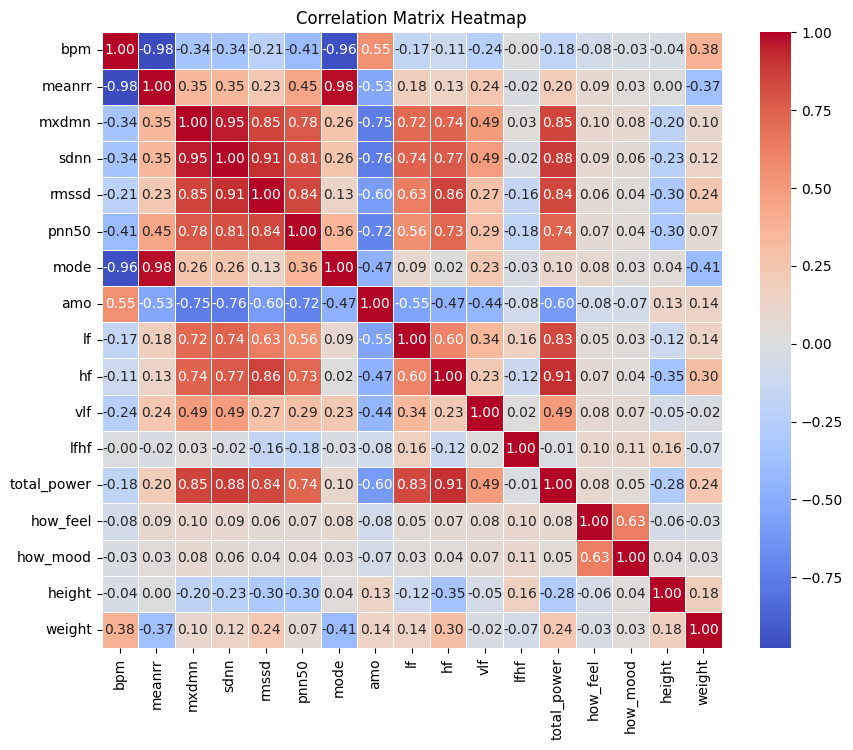

In [224]:
# Variable Relationships
print("\nVariable Relationships")
print("----------------------")
print("Correlation Matrix:")
correlation_matrix = df_par_hrv[df_par_hrv.select_dtypes(include=[np.number]).columns].corr()

# Visualize the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Interpretation**

Heart rate (bpm) shows a strong negative correlation with meanrr (-0.977) and significant relationships with variability metrics like SDNN (-0.341) and RMSSD (-0.214), indicating that higher heart rates are associated with lower heart rate variability.

Meanrr correlates positively with both SDNN (0.348) and RMSSD (0.231), suggesting that lower heart rates align with better heart rate variability.

SDNN and RMSSD demonstrate a strong positive correlation (0.909), reflecting similar underlying physiological processes, while PNN50 also shows strong correlations with SDNN (0.810) and RMSSD (0.843).

### Creating a new feature
1. Body Mass Index: BMI

$BMI = \frac{\text{weight}}{(\text{height})^2}$

BMI estimates a persons body fat based on their height and weight. It is a quick, low-cost and reliable way to determine if someone is underweight, overweight or obese. BMI is used to help detemine a persons risk of developing health issues.


In [225]:
# Since height is in cm and weight is in kg
df_merged['BMI'] = df_merged['weight'] / ((df_merged['height'] ** 2)/10000)
df_merged


,user_code,scale,text,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,mode,...,lfhf,total_power,how_feel,how_mood,gender,age_range,height,weight,symptoms_onset,BMI
0,01bad5a519,S_COVID_OVERALL,Extremely severe,78,768.07,0.10,29.650,21.196,4.04,0.775,...,3.820,713.0,0,0,m,45-54,178.0,92.0,2020-04-05,29.036738
1,01bad5a519,S_COVID_OVERALL,Extremely severe,69,859.91,0.13,31.306,20.753,3.03,0.875,...,4.561,1042.0,0,0,m,45-54,178.0,92.0,2020-04-05,29.036738
2,01bad5a519,S_COVID_OVERALL,Extremely severe,73,823.04,0.12,33.033,22.525,1.01,0.825,...,2.137,618.0,0,0,m,45-54,178.0,92.0,2020-04-05,29.036738
3,01bad5a519,S_COVID_OVERALL,Extremely severe,73,814.16,0.08,23.071,24.118,5.05,0.825,...,0.689,357.0,0,0,m,45-54,178.0,92.0,2020-04-05,29.036738
4,01bad5a519,S_COVID_OVERALL,Extremely severe,84,714.17,0.08,23.613,28.472,9.09,0.725,...,0.672,161.0,0,0,m,45-54,178.0,92.0,2020-04-05,29.036738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,fe6c1b1349,S_COVID_OVERALL,Mild,79,762.99,0.20,54.402,37.644,16.16,0.725,...,2.471,2814.0,-1,-1,f,25-34,173.0,53.0,2020-05-03,17.708577
1870,fe6c1b1349,S_COVID_OVERALL,Mild,91,655.95,0.16,48.130,31.550,9.09,0.625,...,7.212,2637.0,0,0,f,25-34,173.0,53.0,2020-05-03,17.708577
1871,fe6c1b1349,S_COVID_OVERALL,Mild,80,752.38,0.22,63.191,54.655,20.20,0.775,...,4.983,3561.0,1,0,f,25-34,173.0,53.0,2020-05-03,17.708577
1872,fe6c1b1349,S_COVID_OVERALL,Mild,77,782.22,0.19,73.590,52.788,12.12,0.775,...,1.868,1843.0,-1,0,f,25-34,173.0,53.0,2020-05-03,17.708577


### Outlier Analysis

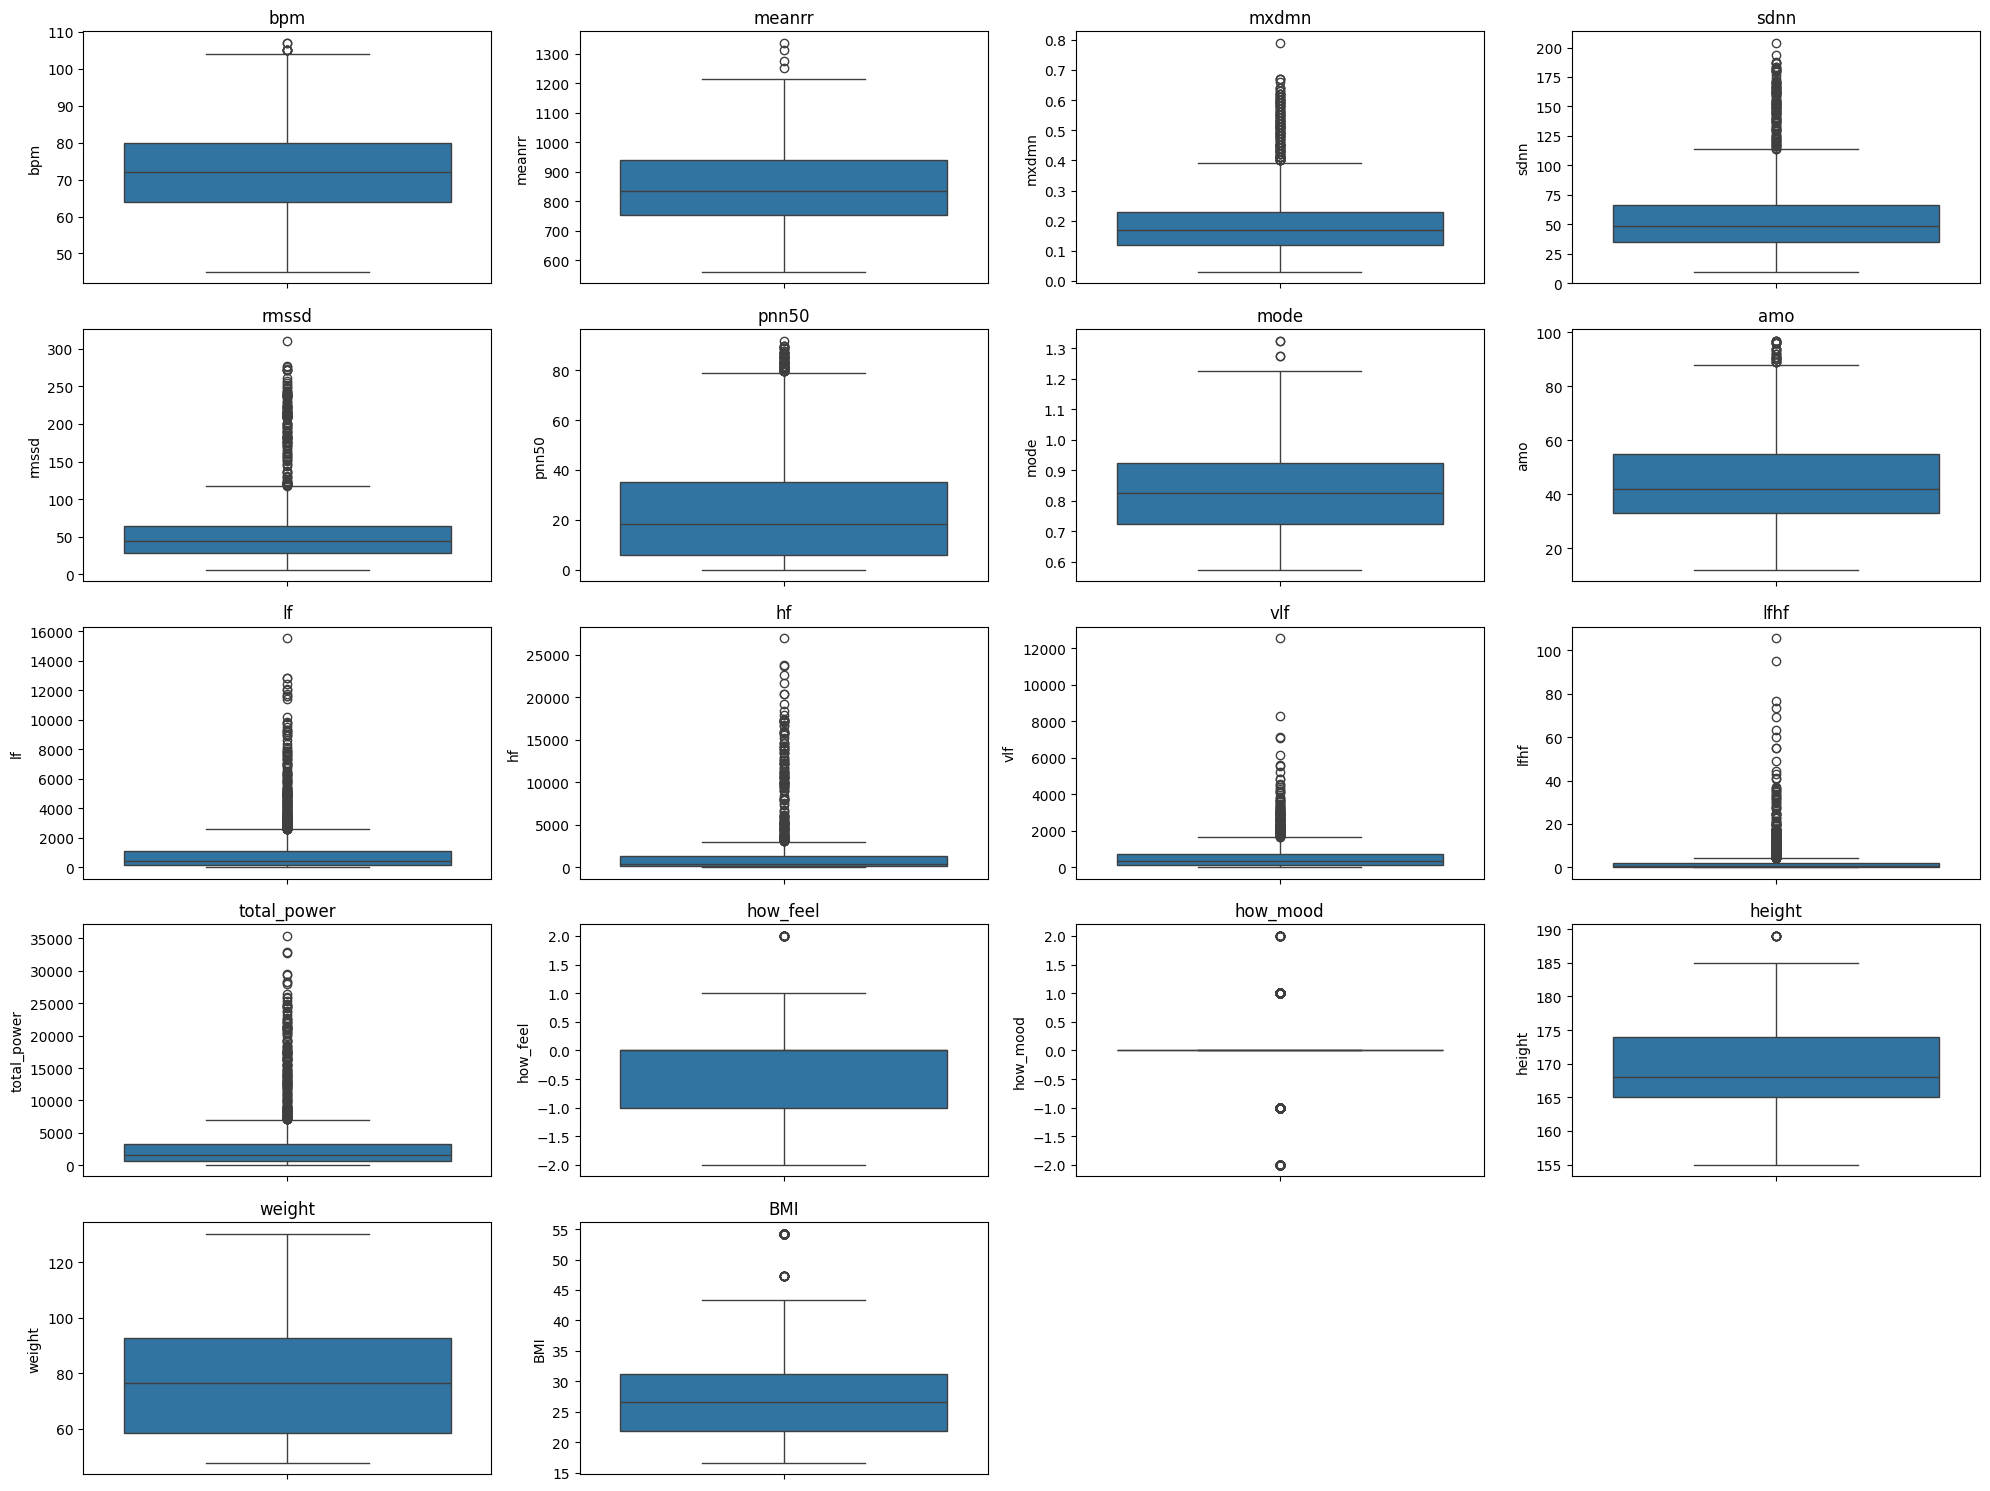

In [226]:
numerical_features = df_merged.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 15))  # Adjust the figure size for better visibility

# Generate a box plot for each numerical feature
for i, feature in enumerate(numerical_features):
    plt.subplot(5, 4, i + 1)  # Changed to 5 rows and 4 columns
    sns.boxplot(y=df_merged[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

**Interpretion**

Several features, including total_power, lf, hf, vlf, and lfhf, exhibit a significant number of outliers. To create a more streamlined and manageable dataset for our analysis, we will exclude these features from further consideration.

In [227]:
df_merged = df_merged.drop(['lf', 'hf', 'vlf', 'lfhf'], axis=1)

## Dimensionality Reduction with PCA and Data Transformation

Principal Components (PC1, PC2, PC3):
The principal components (PCs) are derived from a dimensionality reduction technique (PCA) applied to the HRV- participants-survey dataset. These PCs represent combinations of original features, capturing the most variance in the data.

In [228]:
# Select the features to reduce
df_hrv_features = df_merged[df_merged.select_dtypes(include=[np.number]).columns]

# Exclude BMI and bpm since they are considered seperately while visualizing the pair plot
df_hrv_features = df_hrv_features.drop(['BMI', 'bpm', 'height','weight'], axis=1)

scaler = StandardScaler()
df_hrv_scaled = scaler.fit_transform(df_hrv_features)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(df_hrv_scaled)

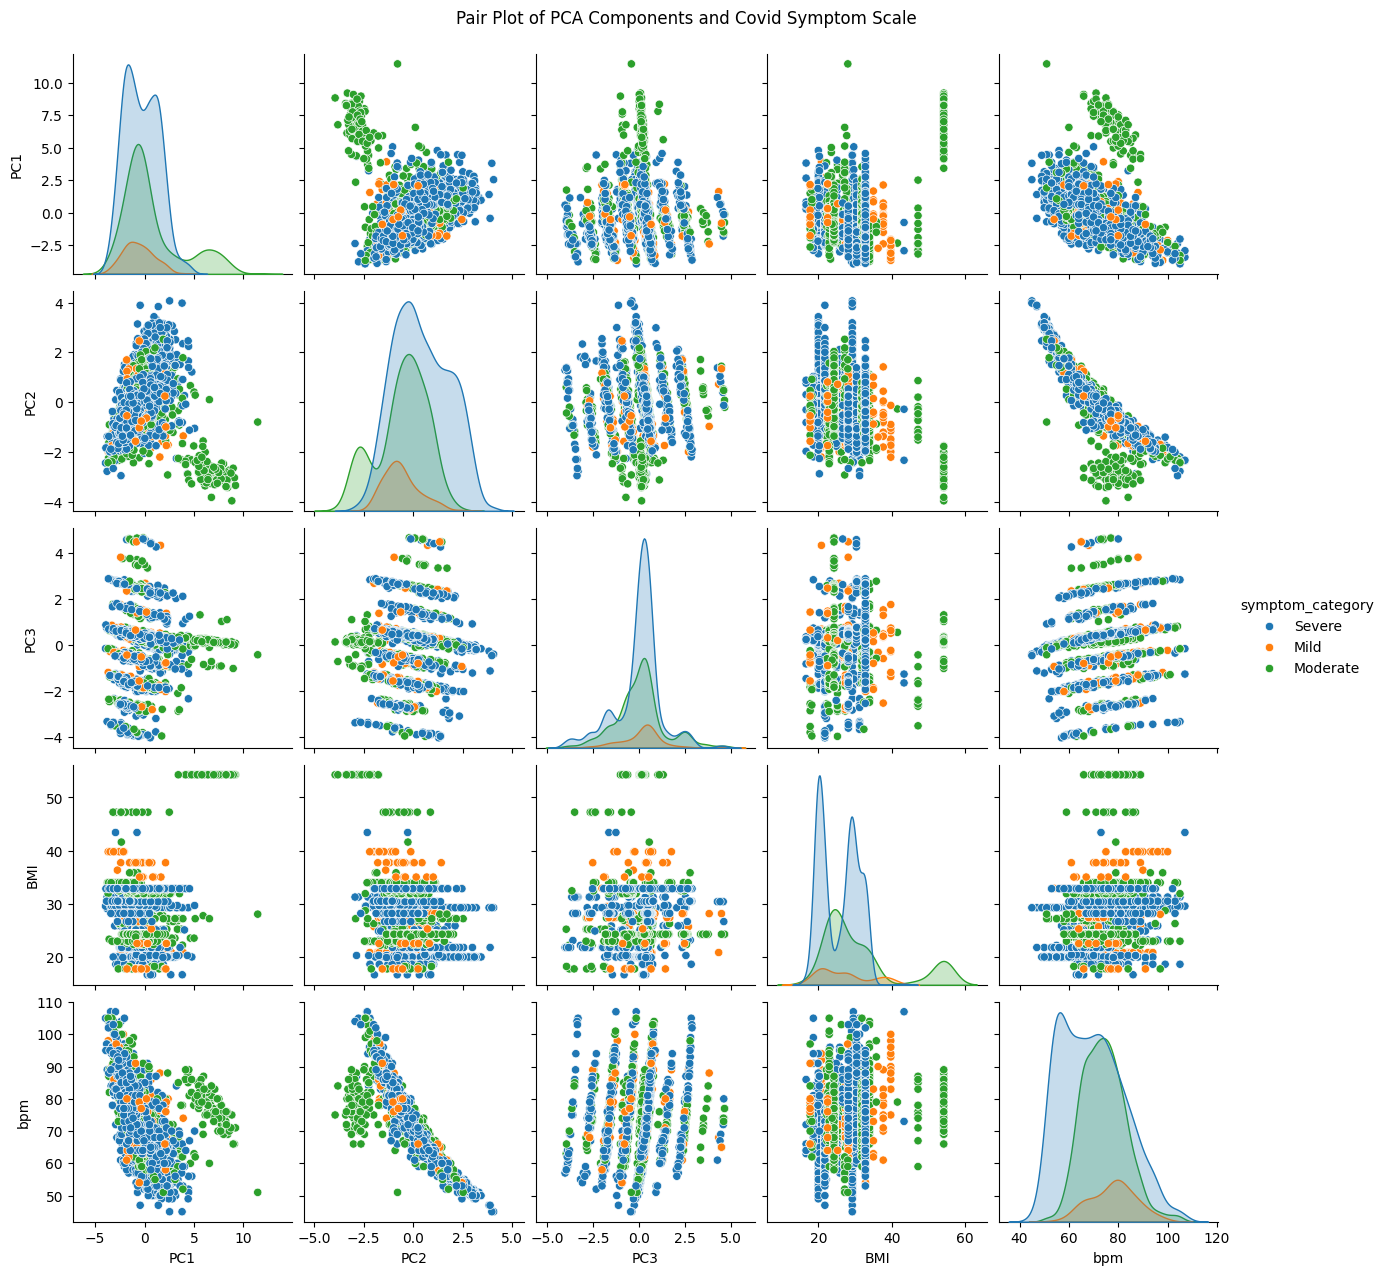

In [229]:
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['BMI'] = df_merged['BMI']
df_pca['bpm'] = df_merged['bpm']
df_pca['text'] = df_merged['text']

# Reducing number of target categories
def merge_categories(category):
    if category == "User isn’t experiencing symptom":
        return 'Mild'
    elif category == 'Very mild':
        return 'Mild'
    elif category == 'Mild':
        return 'Mild'
    elif category == 'Moderate':
        return 'Moderate'
    elif category == 'Severe':
        return 'Severe'
    else:
        return 'Severe'
    
df_pca['symptom_category'] = df_pca['text'].apply(lambda x: merge_categories(x))
df_pca = df_pca.drop(['text'], axis=1)

# Plot the pairplot for the PCA components against BMI category
sns.pairplot(df_pca, hue='symptom_category', markers=["o", "o", "o"])
plt.suptitle('Pair Plot of PCA Components and Covid Symptom Scale', y=1.02)
plt.show()

**Interpretation**


The scatter plots between these PCs (e.g., PC1 vs. PC2, PC1 vs. PC3) show clusters, but there is significant overlap across the symptom severity categories (Severe, Moderate, Very mild).

However, some patterns do emerge: participants with "severe" symptoms (blue) seem to cluster in specific regions of the plot, while "very mild" symptoms (orange) are more dispersed across all dimensions, indicating less consistency in how symptoms manifest.

1. Symptom Severity Distribution:
PC1 and PC2 show the most distinction between symptom categories, especially for severe cases, while PC3 shows more overlap.

For PC1, participants with moderate symptoms seem to show higher values.

2. BMI:
The relationship between BMI and PCs does not show strong differentiation between symptom categories.

3. BPM:
BPM appears to have the most notable relationship with PC1 and PC2.
Participants with severe symptoms (blue) tend to have higher heart rates (clustered around 90-120 bpm), while those with very mild symptoms (orange) generally have lower heart rates (clustered around 60-80 bpm).


#### General Conclusion:
The pair plot indicates that while some features like heart rate (bpm) show a degree of clustering based on symptom severity, others like BMI and the principal components derived from PCA (especially PC1 and PC2) exhibit less clear patterns.

### Data Quality Assessment

#### Data Profiling
Data profiling was done to examine the overall structure and key aspects of the dataset. This included participant demographics, physiological measurements (heart rate, HRV, blood pressure), and symptom data.

#### Data Completeness
Data completeness was a significant consideration across the datasets. Although missing data was present in several files, particularly in the less crucial features like certain wearable metrics, the core variables for analysis, such as bpm, HRV, and symptom scale value, had minimal missing values. As a result, data cleaning was relatively straightforward.

#### Data Accuracy
Outliers and unrealistic values were identified, particularly for physiological metrics such as heart rate, height, and weight.

#### Data Consistency
Ensuring consistency across the different datasets was essential, especially when integrating data from various sources. The primary focus was to standardize measurement units for PCA analysis. The datasets were merged using the user_code field as the unique identifier, guaranteeing that participant-level data remained consistent.

#### Data Integrity
Data integrity was maintained during the cleaning and transformation phases. Care was taken to ensure that no essential information was lost or altered when merging different datasets. Duplicate entries were removed.

#### Data Lineage and Provenance
The data used in this analysis originated from publicly available sources, primarily from health monitoring tools and wearable devices. Each dataset was linked using the unique user_code field to ensure traceability. Throughout the data processing stages, the lineage of the data was documented, allowing for transparent tracking of the transformations and ensuring reproducibility of the final results.